In [46]:
# pytorch mlp for binary classification
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid, ReLU, BatchNorm1d, Dropout, Conv1d, MaxPool1d
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_, kaiming_uniform_, kaiming_normal_

In [47]:
# Constants
PATH = './processed-data/train_relations_not_null_data.csv'
TEST_PATH = './processed-data/test_relations_not_null_data.csv'
# não estão a ser utilizados para já
device = torch.device("cpu")
EPOCHS = 175
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [54]:
# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path):
        # ler o ficheiro csv para um dataframe
        df = pd.read_csv(path, header=0)
        self.dim=df.shape[1]-1
        # separar os inputs e os outputs
        self.X = df.values[:, 1:]
        self.y = df.values[:, 0]
        # garantir que os inputs sejam floats
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        # garantir o shape correto para o label
        self.y = self.y.reshape((len(self.y), 1))

    # número de casos no dataset
    def __len__(self):
        return len(self.X)
    
    # retornar um caso
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    
    def get_dim(self):
        return self.dim
    
    # retornar índices para casos de treino de de teste
    def get_splits(self, n_test=0.33):
        # calcular tamanho para o split
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calcular o split do houldout
        return random_split(self, [train_size, test_size])#, generator=torch.Generator().manual_seed(42))

# preparar o dataset
def prepare_data(path):
    # criar uma instância do dataset
    dataset = CSVDataset(path)
    # calcular split
    train, valdiation = dataset.get_splits()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True) #32 len(train)
    val_dl = DataLoader(valdiation, batch_size=BATCH_SIZE, shuffle=False)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(valdiation, batch_size=len(valdiation), shuffle=False)
    return train_dl, val_dl, train_dl_all, val_dl_all, dataset.get_dim()

# preparar os dados
train_dl, val_dl, train_dl_all, val_dl_all, dim_num = prepare_data(PATH)

In [49]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=None)
    display(df)
def visualize_dataset(train_dl, val_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(val_dl.dataset)}")
    x, y = next(iter(train_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    #print(y)
    
visualize_data(PATH)
visualize_dataset(train_dl, val_dl)

,0,1,2,3,4,5,6,7,8,9,...,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202
0,age,rel-1,rel-3,rel-4,rel-5,rel-8,rel-13,rel-14,rel-15,rel-17,...,rel-3975,rel-3977,rel-3979,rel-3981,rel-3989,rel-3993,rel-3997,rel-3999,rel-4001,rel-4003
1,13,0.13152513068295066,0.0,0.13695039151507568,0.0,0.1463094835282487,0.08504357235067955,0.0,0.27153768530795785,0.6941960106503965,...,0.0,0.0,0.0,0.014926682256188676,0.0,0.0,0.0,0.0,0.5850060523860224,0.2806062271251331
2,14,0.11770352725560888,0.0,0.13299809511232405,0.037714477776214936,0.11342491582310929,0.10540277848429594,0.0,0.316890214857591,0.7569372231801426,...,0.0,0.0,0.0,0.031810609502218194,0.0,0.0,0.0,0.0,0.5994370017818766,0.20747818936911436
3,15,0.15580596397166746,0.0,0.1654291346173953,0.02227817462109693,0.09607963318316486,0.08788987272325399,0.0,0.3480716475756247,0.7844514493117679,...,0.0,0.0,0.0,0.021235216425020506,0.01804999835021417,0.0,0.0,0.0,0.6303735077739404,0.24647167768599754
4,15,0.14521446386863182,0.0,0.1624925814199255,0.0,0.12411458477169271,0.09794939291935065,0.0,0.3102695776218635,0.8006706490445937,...,0.0,0.0,0.0,0.01512992626682297,0.0,0.0,0.0,0.0,0.5625047108732929,0.2878876128467465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,77,0.21576667491869883,0.0,0.18494193783241825,0.01944638473680701,0.1099718901063309,0.1080905684647715,0.0,0.39033165627576394,0.7345744111069945,...,0.03316718489713255,0.015108487167287368,0.01643362637840082,0.056483035772704214,0.0,0.0,0.0,0.011150472478070992,0.6602918558628459,0.3026753383068725
109,67,0.1430050115257508,0.0,0.12435010951472804,0.0,0.09018890248147972,0.08936694625523896,0.0,0.30638034663390734,0.7568276622137461,...,0.0,0.013165506769402877,0.029519462267824488,0.05196410878016795,0.0,0.013097722203527673,0.011170836931819469,0.019141254000135794,0.6304154549754257,0.2041253280576364
110,55,0.1160847843891602,0.0,0.15640598132494415,0.020947137569371364,0.12258930443742344,0.09132464671190622,0.0,0.29094128118908275,0.8008432098836037,...,0.0,0.0,0.0,0.034193295163286515,0.010497958537702952,0.0,0.0,0.0,0.5743547251988937,0.24678357194266243
111,76,0.15665442423941386,0.0,0.16661323459706648,0.04646440036672482,0.0912442211721474,0.14748423338389025,0.017150519037560014,0.3575395968104339,0.6551286183171472,...,0.0,0.0,0.0,0.05149721459467968,0.012696512221254272,0.019894077761544175,0.010225005174065927,0.0,0.6310571080259276,0.21625939656444373


Quantidade de casos de Treino:75
Quantidade de casos de Teste:37
Shape tensor batch casos treino, input: torch.Size([32, 1202]), output: torch.Size([32, 1])
Shape tensor batch casos validação, input: torch.Size([32, 1202]), output: torch.Size([32, 1])


casos_treino:  75
Média_valores_label_Train:  43.0
casos_test:  37
Média_valores_label_Test:  46.972973


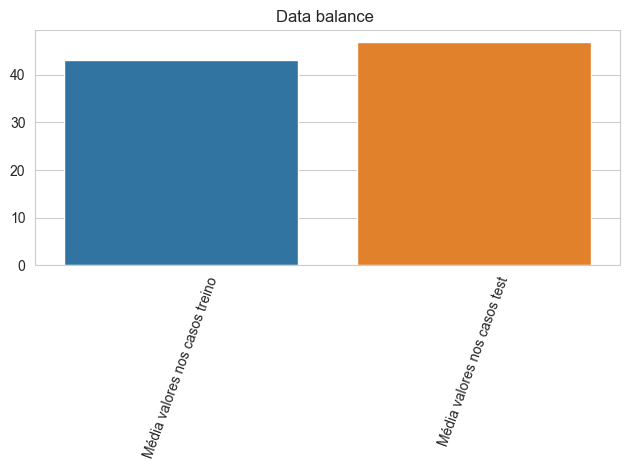

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(train_dl_all, val_dl_all):
    _, y_train = next(iter(train_dl_all))
    _, y_test = next(iter(val_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train)
    casos_test=len(y_test)
    print("casos_treino: ",casos_treino)
    print("Média_valores_label_Train: ", np.mean(y_train.numpy()))
    print("casos_test: ",casos_test)
    print("Média_valores_label_Test: ", np.mean(y_test.numpy()))
    grafico=sns.barplot(x=['Média valores nos casos treino','Média valores nos casos test'],
    y=[np.mean(y_train.numpy()), np.mean(y_test.numpy())])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show()

visualize_holdout_balance(train_dl_all, val_dl_all)

In [56]:
# MLP Regression
from torchinfo import summary

# Definição classe para o modelo
class MLP(Module):
    # definir elementos do modelo
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 600)
        # kaiming_uniform_(self.hidden1.weight)
        self.bn1 = BatchNorm1d(600)
        self.act1 = ReLU()
        
        self.hidden2 = Linear(600, 300)
        # kaiming_uniform_(self.hidden2.weight)
        # self.bn2 = BatchNorm1d(100)
        self.act2 = ReLU()
        self.hidden3 = Linear(300, 150)
        # kaiming_uniform_(self.hidden3.weight)
        # self.bn3 = BatchNorm1d(18)
        self.act3 = ReLU()
        
        # self.dropout = Dropout(0.2)
        self.hidden4 = Linear(150, 75)
        # kaiming_uniform_(self.hidden4.weight)
        self.act4 = ReLU()
        
        # self.dropout = Dropout(0.2)
        self.hidden5 = Linear(75, 1)
        # kaiming_uniform_(self.hidden5.weight)

    def forward(self, X):
        # input para a primeira camada
        X = self.hidden1(X)
        # X = self.conv1(X)
        # X = self.bn1(X)
        X = self.act1(X)
        # X = self.pool1(X)

        # segunda camada
        X = self.hidden2(X)
        # X = self.bn2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        # X = self.bn3(X)
        X = self.act3(X)

        # terceira camada
        # X = self.dropout(X)
        X = self.hidden4(X)
        # X = self.bn3(X)
        X = self.act4(X)
        
        X = self.hidden5(X)
        return X
    
# definir a rede neuronal
model = MLP(dim_num)
# visualizar a rede
print(summary(model, input_size=(BATCH_SIZE, dim_num), verbose=2))#verbose=2 Show weight and bias layers in full detail
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 1]                   1,200
├─Linear: 1-1                            [32, 600]                 721,800
│    └─weight                                                      ├─721,200
│    └─bias                                                        └─600
├─ReLU: 1-2                              [32, 600]                 --
├─Linear: 1-3                            [32, 300]                 180,300
│    └─weight                                                      ├─180,000
│    └─bias                                                        └─300
├─ReLU: 1-4                              [32, 300]                 --
├─Linear: 1-5                            [32, 150]                 45,150
│    └─weight                                                      ├─45,000
│    └─bias                                                        └─150
├─ReLU: 1-6                            

MLP(
  (hidden1): Linear(in_features=1202, out_features=600, bias=True)
  (bn1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=600, out_features=300, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=300, out_features=150, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=150, out_features=75, bias=True)
  (act4): ReLU()
  (hidden5): Linear(in_features=75, out_features=1, bias=True)
)

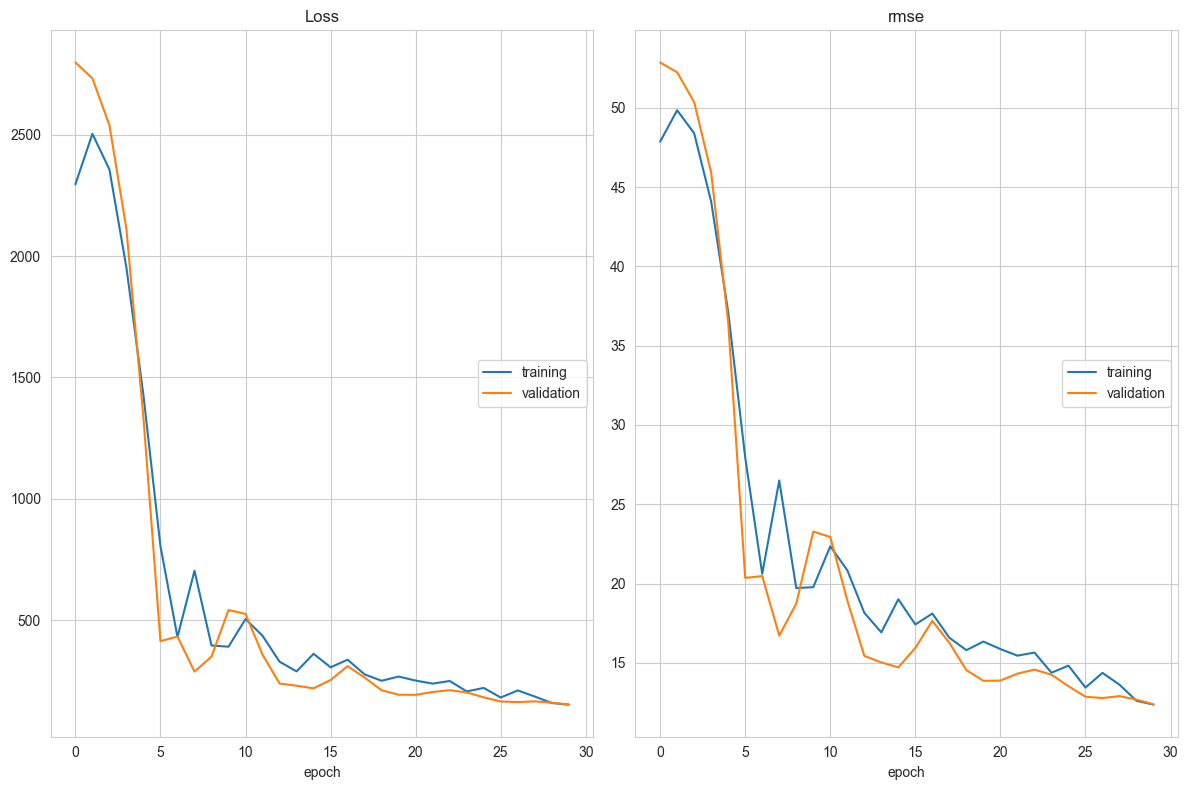

Loss
	training         	 (min:  153.056, max: 2503.044, cur:  153.056)
	validation       	 (min:  153.512, max: 2796.993, cur:  153.512)
rmse
	training         	 (min:   12.368, max:   49.840, cur:   12.368)
	validation       	 (min:   12.390, max:   52.854, cur:   12.390)


In [59]:
#versão com display de gráfico
from livelossplot import PlotLosses

from sklearn.metrics import mean_squared_error

# treino do modelo
def train_model(train_dl, val_dl, model, epochs):
    liveloss = PlotLosses() ##para visualizarmos o processo de treino
    # definir o loss e a função de otimização
    criterion = MSELoss() # neste caso implementa a mean squared error
    #optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) # stochastic gradient descent
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)# iterar as epochs
    for epoch in range(epochs):
        logs = {} ##para visualizarmos o processo de treino
        # iterar as batchs
        epoch_loss = 0 ##para visualizarmos o processo de treino
        epoch_rmse = 0 ##para visualizarmos o processo de treino
        for i, (inputs, labels) in enumerate(train_dl):# backpropagation
            # inicializar os gradientes
            optimizer.zero_grad() # coloca os gradientes de todos os parâmetros a zero
            # calcular o output do modelo
            outputs = model(inputs)
            # calcular o loss
            loss = criterion(outputs, labels)#.unsqueeze(1))
            rmse = np.sqrt(mean_squared_error(labels.reshape((len(labels), 1)).numpy(), outputs.detach().numpy()))
            # atribuição alteraçoes "In the backward pass we receive a Tensor containing the gradient of the loss
            # with respect to the output, and we need to compute the gradient of the loss with respect to the input.
            loss.backward()
            # update pesos do modelo
            optimizer.step()
            # só para multiclass:
            #valores, predictions = torch.max(outputs, 1) #retorna um tensor com os indices do valor maximo em cada caso
            epoch_loss += loss.item()
            epoch_rmse += rmse.item()

        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | RMSE: {epoch_rmse/len(train_dl):.3f}')
        logs['loss'] = epoch_loss/len(train_dl)##para visualizarmos o processo de treino
        logs['rmse'] = epoch_rmse/len(train_dl)##para visualizarmos o processo de treino
        

        # Validation phase
        model.eval()
        # running_loss  = 0.0
        # running_rmse  = 0.0
        # for inputs, labels in val_dl: 
        #     inputs = inputs.to(device)
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     running_loss += loss.detach() * inputs.size(0)
        #     rmse = np.sqrt(mean_squared_error(labels.reshape((len(labels), 1)).numpy(), outputs.detach().numpy()))
        #     running_rmse += rmse.item()
        # epoch_loss = running_loss.item() / len(val_dl.dataset)
        # epoch_rmse = running_rmse / len(val_dl)
        # logs['val_loss'] = epoch_loss
        # logs['val_rmse'] = epoch_rmse

        val_loss = 0
        val_rmse = 0
        for i, (val_inputs, val_labels) in enumerate(val_dl):
            # Perform forward pass
            val_inputs = val_inputs.to(device)
            val_outputs = model(val_inputs)
            
            # Calculate the loss and RMSE
            val_loss_batch = criterion(val_outputs, val_labels)
            val_rmse_batch = np.sqrt(mean_squared_error(val_labels.reshape((len(val_labels), 1)).numpy(), val_outputs.detach().numpy()))
            
            # Accumulate the loss and RMSE
            val_loss += val_loss_batch.item()
            val_rmse += val_rmse_batch.item()

        avg_val_loss = val_loss / len(val_dl)
        avg_val_rmse = val_rmse / len(val_dl)

        logs['val_loss'] = avg_val_loss
        logs['val_rmse'] = avg_val_rmse

        liveloss.update(logs) ##para visualizarmos o processo de treino
        liveloss.send() ##para visualizarmos o processo de treino

# treinar o modelo
model = MLP(dim_num)
train_model(train_dl, val_dl, model, 30)
torch.save(model,"./models/MLP.pth")

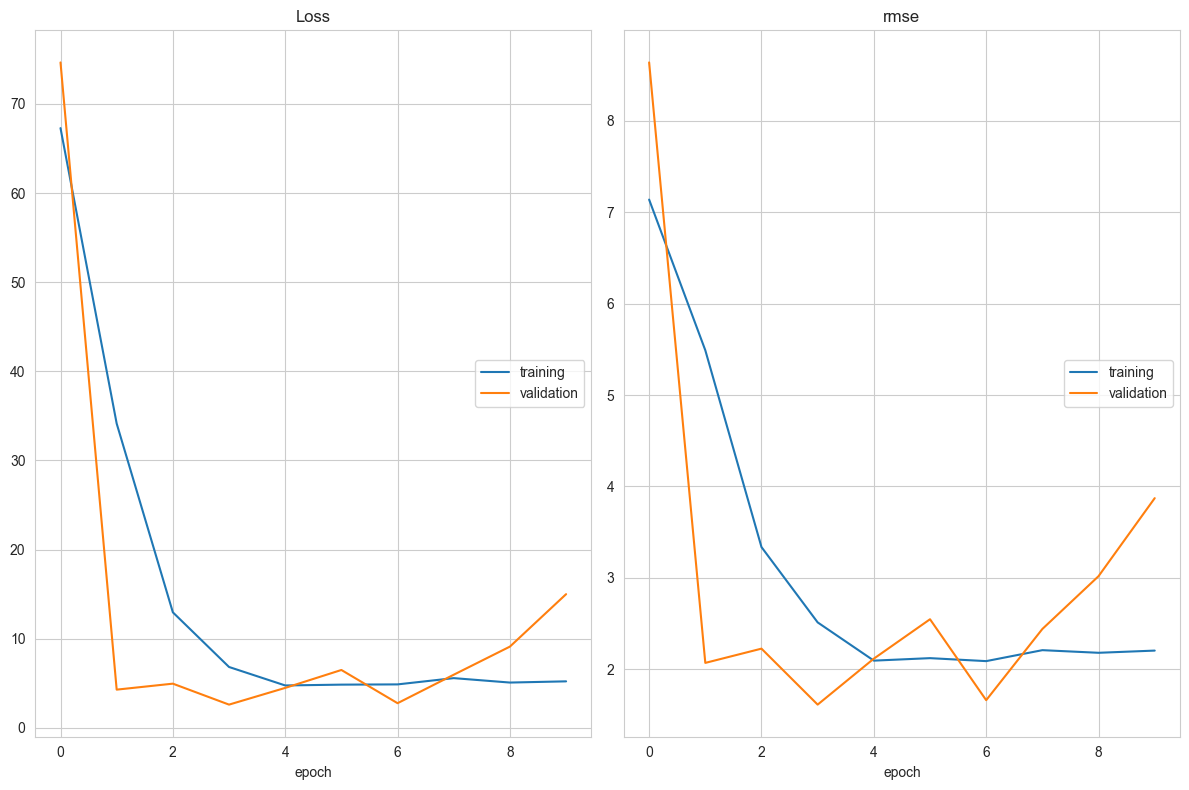

Loss
	training         	 (min:    4.751, max:   67.291, cur:    5.212)
	validation       	 (min:    2.601, max:   74.660, cur:   14.994)
rmse
	training         	 (min:    2.089, max:    7.140, cur:    2.204)
	validation       	 (min:    1.613, max:    8.641, cur:    3.872)


In [60]:
from sklearn.model_selection import KFold

# definição classe para o dataset
class CSVCVDataset(Dataset):
    # ler o dataset
    def __init__(self, df):
        # ler o ficheiro csv para um dataframe
        self.dim=df.shape[1]-1
        # separar os inputs e os outputs
        self.X = df.values[:, 1:]
        self.y = df.values[:, 0]
        # garantir que os inputs sejam floats
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        # garantir o shape correto para o label
        self.y = self.y.reshape((len(self.y), 1))

    # número de casos no dataset
    def __len__(self):
        return len(self.X)
    
    # retornar um caso
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    
    def get_dim(self):
        return self.dim
    
    # retornar índices para casos de treino de de teste
    def get_splits(self, n_test=0.33):
        # calcular tamanho para o split
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calcular o split do houldout
        return random_split(self, [train_size, test_size])#, generator=torch.Generator().manual_seed(42))

# Define the number of folds
k = 10

# Perform cross-validation
data = pd.read_csv(PATH, header=0)
kf = KFold(n_splits=k, shuffle=True)
for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k}")
    
    # Split the data into training and validation sets for this fold
    print(val_index)
    train_data = CSVCVDataset(data.iloc[train_index])
    val_data = CSVCVDataset(data.iloc[val_index])
    print(type(val_data))
    
    # Create train and validation data loaders
    train_dl2 = DataLoader(train_data, batch_size=len(val_data), shuffle=True)
    val_dl2 = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
    
    # Load model
    try:
        model= torch.load("./models/MLP-cross.pth") ### modelo treinado anteriormente
    except:
        model= torch.load("./models/MLP.pth") ### modelo treinado anteriormente
    
    # Train the model
    train_model(train_dl2, val_dl2, model, 10)
    torch.save(model,"./models/MLP-cross.pth") ### guardar o modelo após treinado

In [61]:
def evaluate_model(val_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(val_dl):
        # avaliar o modelo com os casos de teste
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        actual = actual.reshape((len(actual), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

# avaliar o modelo
actual_values, predictions = evaluate_model(val_dl, model)
#actuals, predictions = evaluate_model(train_dl, model)
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}')
# calcular a accuracy
mse = mean_squared_error(actual_values, predictions)
print(f'MSE: {mse:0.3f}, RMSE: {np.sqrt(mse):0.3f}\n')

real:[62.] previsão:[65.85419]
real:[58.] previsão:[62.915417]
real:[16.] previsão:[18.688505]
real:[51.] previsão:[53.59235]
real:[51.] previsão:[53.493496]
real:[16.] previsão:[20.50545]
real:[77.] previsão:[81.3375]
real:[16.] previsão:[18.361513]
real:[18.] previsão:[21.860987]
real:[57.] previsão:[59.484467]
real:[59.] previsão:[61.998615]
real:[15.] previsão:[19.73699]
real:[22.] previsão:[27.356674]
real:[46.] previsão:[43.813686]
real:[62.] previsão:[65.68806]
real:[76.] previsão:[80.5002]
real:[24.] previsão:[22.626474]
real:[67.] previsão:[70.80804]
real:[76.] previsão:[77.90402]
real:[70.] previsão:[72.91916]
real:[65.] previsão:[69.70624]
real:[18.] previsão:[18.96491]
real:[71.] previsão:[74.43948]
real:[40.] previsão:[37.35656]
real:[64.] previsão:[65.093056]
real:[69.] previsão:[72.64608]
real:[63.] previsão:[65.54103]
real:[27.] previsão:[29.876818]
real:[26.] previsão:[26.610186]
real:[27.] previsão:[30.28784]
real:[57.] previsão:[61.231377]
real:[16.] previsão:[17.103

In [62]:
# definição classe para o dataset
class CSVTestDataset(Dataset):
  # ler o dataset
  def __init__(self, dataframe):
    # separar os inputs e os outputs
    self.x = torch.tensor(dataframe.values, dtype=torch.float32)
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    data = self.x[idx]       
    return data

def prepare_test_data_loaders(path_train):
  test_df = pd.read_csv(path_train, header=0)

  # Create the training and validation datasets
  test = CSVTestDataset(test_df)

  # Create the training and validation dataloaders
  test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
  test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

  return test_dl, test_dl_all

In [63]:
val_dl, val_dl_all = prepare_test_data_loaders(TEST_PATH)

model.eval()

predictions_ = []

with torch.no_grad():
    for data in val_dl:
        data = data.to(device)
        output = model(data)
        predictions_.extend(output.tolist())

predictions = []
for prediction in predictions_:
    for p in prediction:
        predictions.append(int(p))

result = pd.read_csv('./data/example_submission.csv')
result['age']=predictions
result.to_csv('./results/res.csv', index=False)

In [64]:
csv = pd.read_csv('./results/sub6.csv', header=0)
print(csv)

    id  age
0    1   24
1    2   62
2    3   86
3    4   54
4    5   30
5    6   25
6    7   27
7    8   57
8    9   25
9   10   30
10  11   58
11  12   63
12  13   69
13  14   62
14  15   55
15  16   65
16  17   36
17  18   26
18  19   66
19  20   64
20  21   26
21  22   31
22  23   61
23  24   51
24  25   24
25  26   57
26  27   62
27  28   28
